In [1]:
# Don't forget to run every block of code from start to end

# Enter a random strings for using a seed 
intforrandom = "a"

import math
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Adding the following line, allows Jupyter Notebook to visualize plots
# Produced by matplotlib directly below the code cell which generated those.
%matplotlib inline
import seaborn as sns
from scipy.stats import pearsonr
#from nose.tools import assert_equal   ---> not working on every version of python so don't use it

# Import stats module from scipy, which contains a large number 
# Of probability distributions as well as an exhaustive library of statistical functions.
import scipy.stats as stats
# Import the sub-module 'linear_model' of scikit-learn
# This sub-module implements generalized linear models.
# API: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
from sklearn import linear_model
# Import two quality metrics which will be used to assess the quality
# Of our predictions: MSE and R squared (a.k.a. coefficient of determination)
from sklearn.metrics import mean_squared_error, r2_score

EPSILON = .0000001 # Tiny tolerance for managing subtle differences resulting from floating point operations

DATASET_FILE = "dataset.csv"

In [2]:
# Load the dataset stored at `DATASET_FILE` using "," as field separator and '?' to detect NAs
# and the specified columns as header

# column names used as header
columnnames = ['id', 'name', 'type_1', 'type_2', 'total', 'hp', 'attack', 'defense', 
            'special_attack', 'special_defense', 'speed', 'generation', 'is_legendary']

# load dataset
data = pd.read_csv(DATASET_FILE, 
                   sep=',',
                   header=0,
                   names=columnnames,
                   na_values='?')

# Remove any duplicates
data = data.drop_duplicates('id', keep='first', inplace=False)
data.reset_index(inplace=True, drop=True)
np.random.seed(np.abs(hash(intforrandom))// 100000000000)
data.iloc[np.random.choice(721, np.random.randint(1,20), replace=False).tolist(), 6] = np.nan
data.iloc[np.random.choice(721, np.random.randint(1,20), replace=False).tolist(), 2] = np.nan
data.iloc[np.random.choice(721, np.random.randint(1,20), replace=False).tolist(), 8] = np.nan
print("Loaded `Pokemon` dataset into a dataframe of size ({} x {})".format(data.shape[0], data.shape[1]))

data.head()

Loaded `Pokemon` dataset into a dataframe of size (721 x 13)


,id,name,type_1,type_2,total,hp,attack,defense,special_attack,special_defense,speed,generation,is_legendary
0,1,Bulbasaur,Grass,Poison,318,45,49.0,49,65.0,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62.0,63,80.0,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,NaN,83,100.0,100,80,1,False
3,4,Charmander,Fire,NaN,309,39,52.0,43,60.0,50,65,1,False
4,5,Charmeleon,Fire,NaN,405,58,64.0,58,80.0,65,80,1,False


## Handle the missing values

In the cell below, you can see the missing values in each column. Then, handle the missing values appropriately. In other words, it deletes the column if it has too many missing values, or replace the missing values using proper techniques.

In [3]:
print(data.isnull().sum())
# Deletes the type_2 column as we have too many nan values
del data["type_2"]

# Deletes the rows with missing type_1 as we can't know the correct type of the pokemon
data.dropna(subset=["type_1"], inplace=True)

# Calculates the mean of the other pokemons that have same types and replace the missing attacks with that number
# Calculate mean attack by "type_1"
mean_attack_by_type = data.groupby("type_1")["attack"].mean().reset_index()
mean_attack_by_type.columns = ["type_1", "mean_attack"]

# Merge the mean attack values back into the original DataFrame so we can replace the values
data = data.merge(mean_attack_by_type, on="type_1", how="left")

# Replace missing "attack" values with the mean of the same type
data["attack"] = data["attack"].fillna(data["mean_attack"])

# Drop the "mean_attack" column as it is no longer needed
data.drop(columns=["mean_attack"], inplace=True)

# In the same fashion, it calculates the mean of the other pokemons that have same types and replaces the missing "sp_attack" with that number
# Calculate mean attack by "type_1"
mean_attack_by_type = data.groupby("type_1")["special_attack"].mean().reset_index()
mean_attack_by_type.columns = ["type_1", "mean_attack"]

# Merges the mean attack values back into the original DataFrame
data = data.merge(mean_attack_by_type, on="type_1", how="left")

# Replaces missing "attack" values with the mean for that type
data["special_attack"] = data["special_attack"].fillna(data["mean_attack"])

# Drops the "mean_attack" column as it is no longer needed
data.drop(columns=["mean_attack"], inplace=True)

print(data.isnull().sum())

id                   0
name                 0
type_1              18
type_2             371
total                0
hp                   0
attack              18
defense              0
special_attack       2
special_defense      0
speed                0
generation           0
is_legendary         0
dtype: int64
id                 0
name               0
type_1             0
total              0
hp                 0
attack             0
defense            0
special_attack     0
special_defense    0
speed              0
generation         0
is_legendary       0
dtype: int64


## Analyze the data using box plots

In the cell below, it creates box plots to analyze your data. Specifies the number of outliers at each column in the next cell.

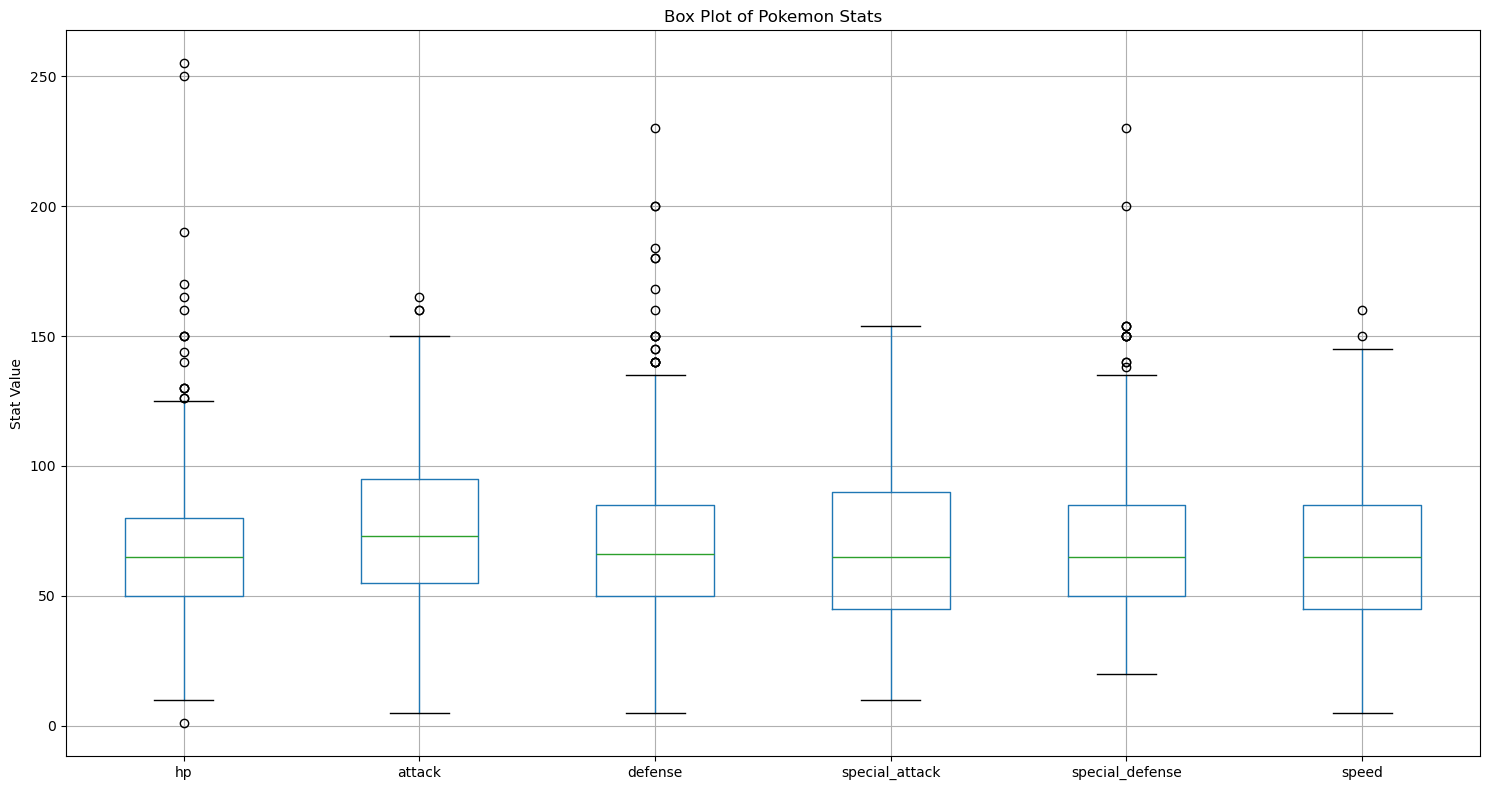

In [4]:
columns_to_plot = ["hp", "attack", "defense", "special_attack", "special_defense", "speed"]

# Set the size of figure
plt.figure(figsize=(15, 8))

# Use boxplot for plotting
data[columns_to_plot].boxplot()

plt.title("Box Plot of Pokemon Stats")
plt.ylabel("Stat Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Finding the 1st quartile
Q1 = data[columns_to_plot].quantile(0.25)
# Finding the 3rd quartile
Q3 = data[columns_to_plot].quantile(0.75)
# Finding the iqr region
IQR = Q3 - Q1

# Finding upper and lower whiskers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding the number of outliers
outliers_count = ((data[columns_to_plot] < lower_bound) | (data[columns_to_plot] > upper_bound)).sum()
print(outliers_count)

hp                 17
attack              3
defense            19
special_attack      0
special_defense    13
speed               2
dtype: int64


## Handle the outliers

In the cell below it handles the outliers using the winsorizing (or log scaling if necessary) technique. Then creates the box plots to show that there are no more outliers.

In [6]:
columns_to_handle = ["hp", "attack", "defense", "special_attack", "special_defense", "speed"]

# Finding the values at 5th percentile
Q_005 = data[columns_to_plot].quantile(0.05)
# Finding the values at 95th percentile
Q_95 = data[columns_to_plot].quantile(0.95)

print(Q_005)
print(Q_95)

# Winsorizing the data
for col in columns_to_handle:
    data[col] = stats.mstats.winsorize(data[col], limits=0.05, inplace=True)

hp                 35.0
attack             30.0
defense            35.0
special_attack     30.0
special_defense    31.1
speed              25.0
Name: 0.05, dtype: float64
hp                 108.9
attack             125.0
defense            124.7
special_attack     125.0
special_defense    119.6
speed              110.0
Name: 0.95, dtype: float64


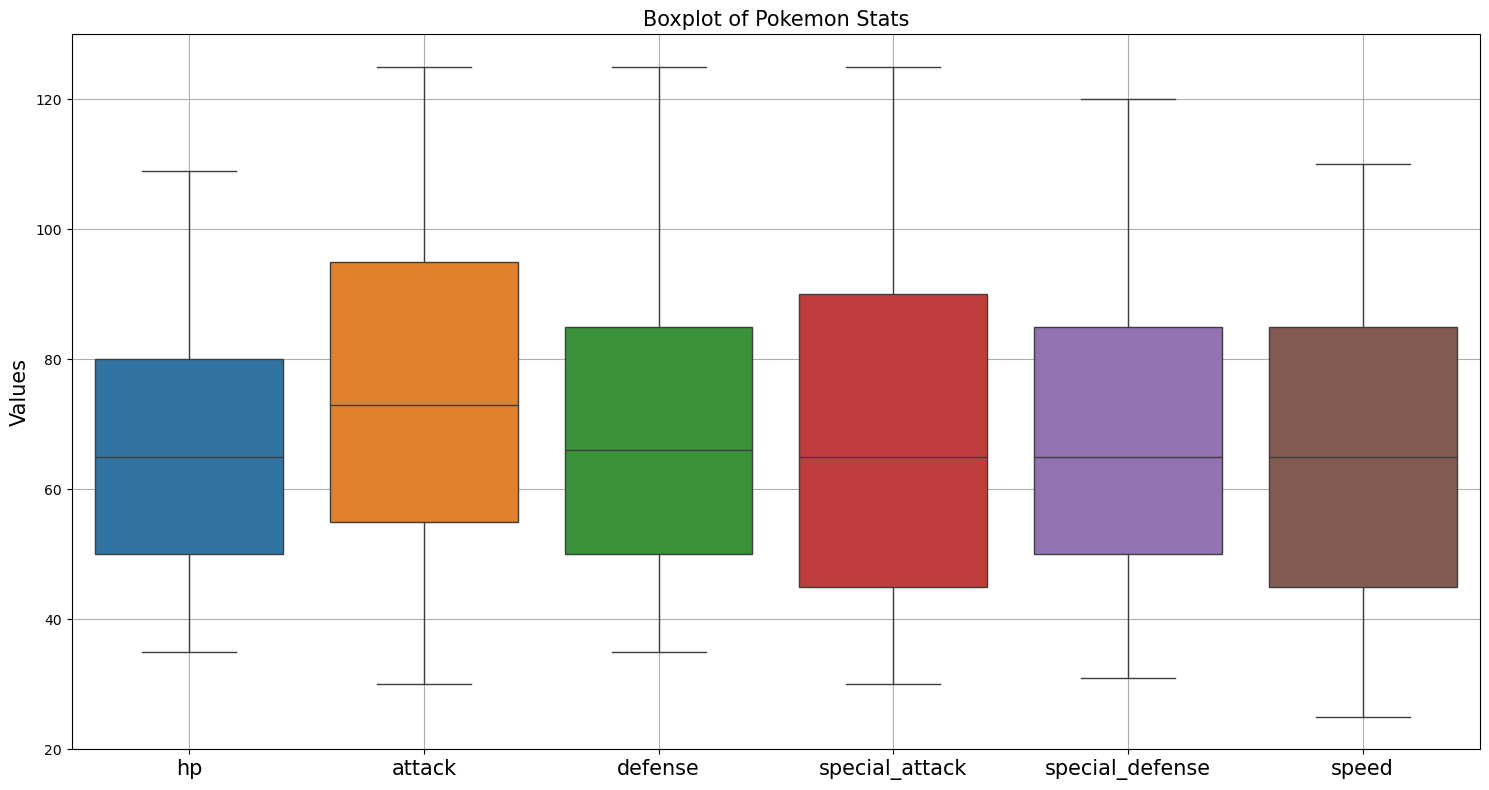

In [7]:
# Creates box plots to check if there are still any outliers after removal

plt.figure(figsize=(15, 8))
sns.boxplot(data=data[columns_to_plot])
plt.ylabel("Values", fontsize=15)
plt.xticks(fontsize = 15)
plt.title("Boxplot of Pokemon Stats", fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()

## Handle the categorical data

In the cell below it handles the categorical data. Note that, if a categorical column has too many distinct values you may remove that column altogether.

In [8]:
# Dropped unnecessary columns as we don't need these to train our Linear Regression model
data.drop(columns=["id", "name"], inplace=True)

# One-Hot encode "type_1"
data = pd.get_dummies(data, columns=["type_1"])

# One-Hot encode "generation"
data = pd.get_dummies(data, columns=["generation"])

# Binary encode "is_legendary"
data["is_legendary"] = data["is_legendary"].astype(int)

## Train linear regression model to estimate total

In the cell below, it prepares your data in order to train a linear classifier to estimate the column name: **total**. Prepare a dataframe **X** which contains your features and a dataframe **y** that contains your target variable.

In [9]:
X = data.drop(columns=["total"])
y = data["total"]

In the cell below, it splits your data using 80%, 20% train-test split.

In [10]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets as 80% and 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In the cell below, it trains and tests your linear classifier using scikit-learn. Reports the mse values for training and testing predictions. Also plot true totals vs. predicted totals for train and test sets.

MSE Values
176.16021988851662
408.8558619081869
R2 Score Values
0.982938750005735
0.9637816351028263


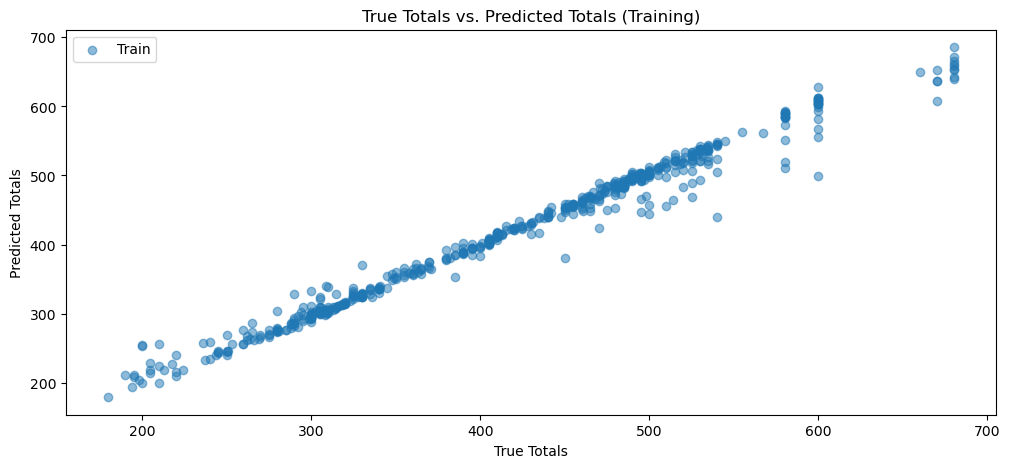

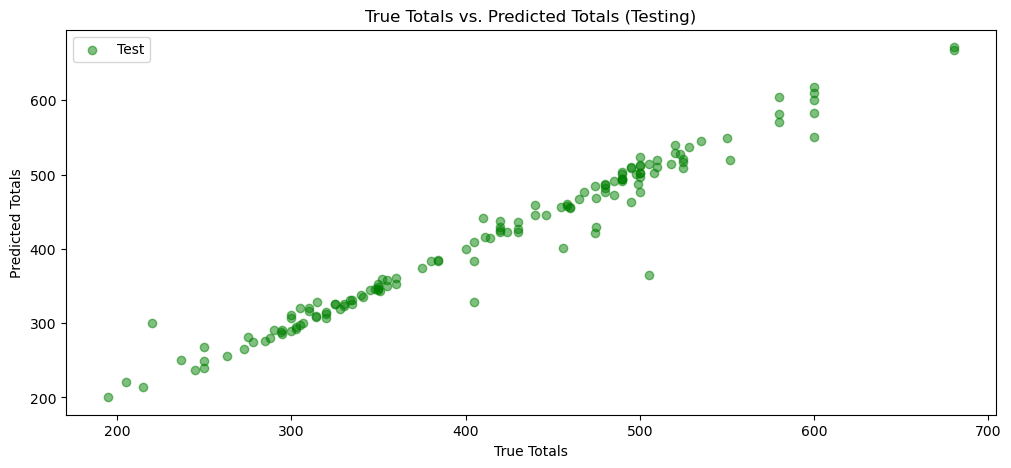

In [11]:
# Create linear regression object
model = linear_model.LinearRegression()

# Separate the datasets because we have an unbalanced amount of "is_legendary" values
X_train_legendary = X_train[X_train["is_legendary"] == 1]
y_train_legendary = y_train[X_train["is_legendary"] == 1]
X_train_non_legendary = X_train[X_train["is_legendary"] == 0]
y_train_non_legendary = y_train[X_train["is_legendary"] == 0]

# Train separate models
model_legendary = model.fit(X_train_legendary, y_train_legendary)
model_non_legendary = model.fit(X_train_non_legendary, y_train_non_legendary)

# Predict on training and testing data
y_test_prediction = np.where(X_test["is_legendary"] == 1, model_legendary.predict(X_test), model_non_legendary.predict(X_test))
y_train_prediction = np.where(X_train["is_legendary"] == 1, model_legendary.predict(X_train), model_non_legendary.predict(X_train))

# Separate test predictions by "is_legendary"
y_test_true_legendary = y_test[X_test["is_legendary"] == 1]
y_test_prediction_legendary = y_test_prediction[X_test["is_legendary"] == 1]

y_test_true_non_legendary = y_test[X_test["is_legendary"] == 0]
y_test_prediction_non_legendary = y_test_prediction[X_test["is_legendary"] == 0]

# Calculate the mean squared error
mse_legendary = mean_squared_error(y_test_true_legendary, y_test_prediction_legendary)
mse_non_legendary = mean_squared_error(y_test_true_non_legendary, y_test_prediction_non_legendary)
print("MSE Values")
print(mse_legendary)
print(mse_non_legendary)

# Wanted to calculate the r2 score too as it was imported in the beginning of the notebook
r2_legendary = r2_score(y_train, y_train_prediction)
r2_non_legendary = r2_score(y_test, y_test_prediction)
print("R2 Score Values")
print(r2_legendary)
print(r2_non_legendary)

# Plot True Totals vs. Predicted Totals for Training Set
plt.figure(figsize=(12, 5))
plt.scatter(y_train, y_train_prediction, alpha=0.5, label="Train")
plt.title("True Totals vs. Predicted Totals (Training)")
plt.xlabel("True Totals")
plt.ylabel("Predicted Totals")
plt.legend()
plt.show()

# Plot True Totals vs. Predicted Totals for Testing Set
plt.figure(figsize=(12, 5))
plt.scatter(y_test, y_test_prediction, alpha=0.5, color="green", label="Test")
plt.title("True Totals vs. Predicted Totals (Testing)")
plt.xlabel("True Totals")
plt.ylabel("Predicted Totals")
plt.legend()
plt.show()